In [5]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

## import code

In [7]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

patch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = np.transpose(patch,(2,0,1))
x_train_orig = np.copy(x_train)

In [10]:
num_classes = 10
loss_fn = nn.CrossEntropyLoss()
#model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_art = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), preprocessing=(mean,std))
model_art.fit(x_train, y_train, batch_size=128, nb_epochs=80,verbose=True)
predictions = model_art.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Epochs: 100%|██████████| 80/80 [14:23<00:00, 10.80s/it]


Accuracy on benign test examples: 57.440000000000005%


## Define Source and Target Class



In [11]:
class_source = 0
class_target = 1
K = 1000

## Select Triggers from Source Class and helper functions for calculating Success Rate

In [12]:
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target
   

## Generate Poison Images through attack

In [14]:
x_trigger, y_trigger, index_target = select_trigger_train(x_train, y_train, K, class_source, class_target)

attack = SleeperAgentAttack(
    model_art,
    percent_poison=0.50,
    max_trials=1,
    max_epochs=50,  # 这里的 max_epochs 设置为 50
    learning_rate_schedule=(np.array([1e-1, 1e-2]), [25, 40]),  # 修改学习率调度的变化点，以符合 max_epochs
    epsilon=16/255,
    batch_size=500,
    verbose=1,
    indices_target=index_target,
    patching_strategy="random",
    selection_strategy="max-norm",
    patch=patch,
    retraining_factor=4,
    model_retrain=True,
    model_retraining_epoch=80,
    retrain_batch_size=128,
    class_source=class_source,
    class_target=class_target,
    device_name=str(device)
)

# generate poison data
x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train, x_test, y_test)

# get posion data index
indices_poison = attack.get_poison_indices()


100%|██████████| 1/1 [31:27<00:00, 1887.64s/it]


## Check indices selected for poisoning


In [15]:
indices_poison.sort()
indices_poison


array([   1,   10,   11, ..., 4993, 4998, 4999])

## Train Victim Model with poisoned images


In [16]:
loss_fn = nn.CrossEntropyLoss()
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_poisoned = PyTorchClassifier(model,input_shape=x_train.shape[1:], loss=loss_fn, 
                                   optimizer=optimizer, nb_classes=10, clip_values=(min_, max_), 
                                   preprocessing=(mean,std))
model_poisoned.fit(x_poison, y_poison, batch_size=128, nb_epochs=150,verbose=1)
predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))


Epochs: 100%|██████████| 150/150 [18:22<00:00,  7.35s/it]


Accuracy on benign test examples: 59.67%


## Visualize Trigger, Original and Poisoned Images


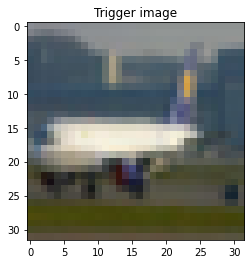

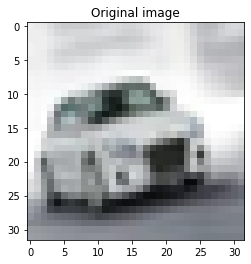

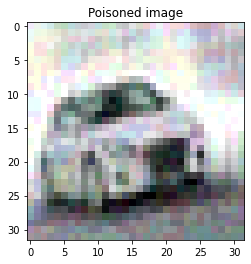

In [17]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(x_trigger[5],(1,2,0)))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(np.transpose(x_train_orig[index_target[indices_poison][5]],(1,2,0)))
plt.title('Original image')
plt.show()

plt.imshow(np.transpose(x_poison[index_target[indices_poison][5]],(1,2,0)))
plt.title('Poisoned image')
plt.show()



## Calculate Success Rate on x_train and x_test


In [18]:
def add_trigger_patch(x_set,patch_type="fixed"):
    print(x_set.shape)
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    print("shape of numpydata",numpydata.shape)
    patch = resize(numpydata, (patch_size,patch_size,3))
    patch = np.transpose(patch,(2,0,1))
    print("shape of patch",patch.shape)
    if patch_type == "fixed":
        x_set[:,:,-patch_size:,-patch_size:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[:,x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]=patch

    return x_set

(1000, 3, 32, 32)
shape of numpydata (80, 80, 3)
shape of patch (3, 8, 8)
1000
Test Success Rate: 0.072


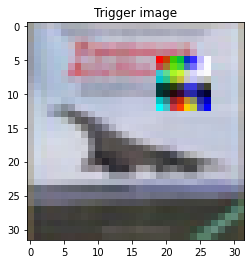

In [19]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(np.transpose(x_test_trigger[0],(1,2,0)))
plt.title('Trigger image')
plt.show()